In [78]:
# Para tratamento dos dados
import pandas as pd
import numpy as np

# Para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

# Para calcular métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Tratando coluna TotalCHarges**

In [4]:
def total_charges_to_float(df_, to_print=False):
    
    if to_print:
        # Verificando porcentagem de valores nulos
        na_perc = (df['TotalCharges'].str.len() == 0).sum()/len(df)
        print(f'Porcentagem de valores nulos na coluna "TotalCharges": {na_perc*100:.3f}%')

    # Removendo espaços
    df_['TotalCharges'] = df_['TotalCharges'].str.strip()
    # Encontrando linhas nulas
    na_rows = df_['TotalCharges'].str.len() == 0
    # Substituindo linhas nulas por NaNs
    df_.loc[na_rows, 'TotalCharges'] = np.nan
    
    # Convertendo para float
    df_['TotalCharges'] = df_['TotalCharges'].astype(np.float64)
    
    return df_

In [5]:
df = total_charges_to_float(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Descrição dos dados:**

Como mostrado acima, o conjunto de dados contém 19 variáveis ​​independentes, que podem ser classificadas em 3 grupos:

### [1] Informações Demográficas

`gender`: se o cliente é do sexo feminino ou masculino (`female`, `male`).

`SeniorCitizen`: 

`Partner`: 

`Dependents`: 

### [2] Informações da conta do cliente

`tenure`: 

`Contract`: 

`PaperlessBilling`: 

`PaymentMethod`: 

`MonthlyCharges`: 

`TotalCharges`: 

### [3] Services Information

`PhoneService`: 

`MultipleLines`: 

`InternetService`: 

`OnlineSecurity`: 

`OnlineBackup`: 

`DeviceProtection`: 

`TechSupport`: 

`StreamingTV`: 

`StreamingMovies`: 




## Ajustes para visualizações

In [12]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [15]:
# remove (automatic) from payment method names
df['PaymentMethod'] = df['PaymentMethod'].str.replace(' (automatic)', '', regex=False)
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

## Dataviz

In [56]:
churn_counts = df.groupby('Churn')['customerID'].count()
churn_percents = (churn_counts/churn_counts.sum()).round(3).to_frame().rename({'customerID': 'percentual'}, axis=1).reset_index()
churn_percents

,Churn,percentual
0,No,0.735
1,Yes,0.265


In [109]:
import matplotlib.ticker as mtick

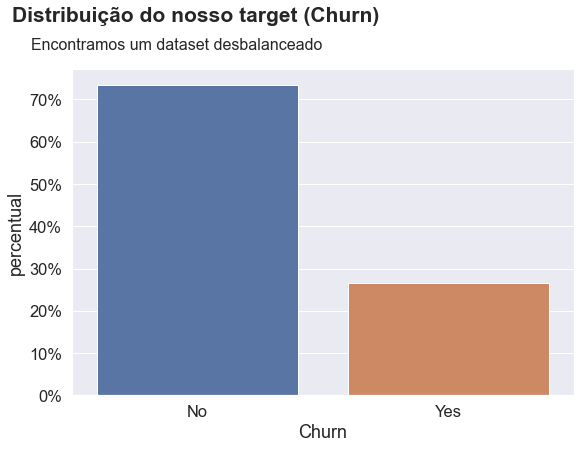

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
fig.suptitle('Distribuição do nosso target (Churn)', weight='bold', horizontalalignment='right', y=1.025, x=0.60, fontsize=21)
ax.set_title('Encontramos um dataset desbalanceado', pad=20, horizontalalignment='right', fontsize=16)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
sns.barplot(data=churn_percents, x='Churn', y='percentual', ax=ax);

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

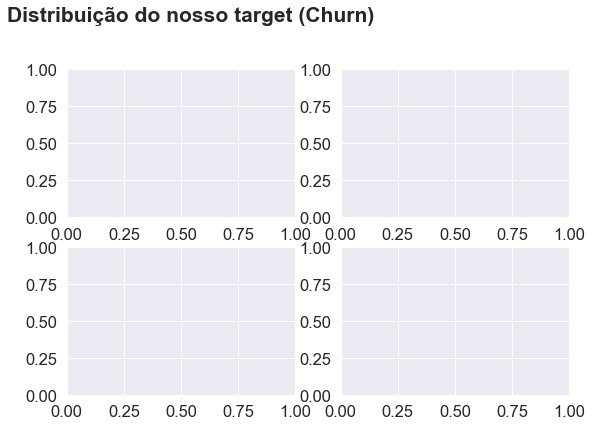

In [112]:
fig, ax = plt.subplots(2, 2, figsize=(9,6))
fig.suptitle('Informação demográfica', weight='bold', horizontalalignment='right', y=1.025, x=0.60, fontsize=21)
ax.set_title('Encontramos um dataset desbalanceado', pad=20, horizontalalignment='right', fontsize=16)
sns.barplot(data=churn_percents, x='Churn', y='percentual', ax=ax);

In [121]:
pd.crosstab(df['gender'], df['Churn']).apply(lambda x: x/x.sum(), axis=1).T

gender,Female,Male
Churn,,
No,0.730791,0.738397
Yes,0.269209,0.261603


In [ ]:
df['gender']

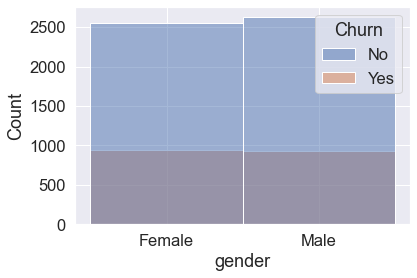

In [127]:
sns.histplot(data=df, x='gender', hue='Churn', color=sns.color_palette());
#plt.legend()

In [125]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]